## 3.4 Import des librairies

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

import findspark
findspark.init()
findspark.find()

from pyspark.ml.functions import vector_to_array
from pyspark.ml.functions import array_to_vector
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql.functions import count
from pyspark.sql import SparkSession

In [2]:
!python -V

Python 3.9.16


In [3]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

Pillow==9.3.0
matplotlib==3.5.2
keras==2.11.0
tensorflow==2.11.0
findspark==2.0.1
numpy==1.21.5
pandas==1.4.4


## 3.5 Définition des PATH pour charger les images <br /> et enregistrer les résultats

Dans cette version locale nous partons du principe que les données <br />
sont stockées dans le même répertoire que le notebook.<br />
Nous n'utilisons qu'un extrait de **300 images** à traiter dans cette <br />
première version en local.<br />
L'extrait des images à charger est stockée dans le dossier **Test1**.<br />
Nous enregistrerons le résultat de notre traitement <br />
dans le dossier "**Results_Local**"

In [4]:
os.getcwd()

'C:\\Users\\multi\\Desktop\\Projets_DS\\P8_ds'

In [5]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        C:\Users\multi\Desktop\Projets_DS\P8_ds
PATH_Data:   C:\Users\multi\Desktop\Projets_DS\P8_ds/data/Test1
PATH_Result: C:\Users\multi\Desktop\Projets_DS\P8_ds/data/Results


In [6]:
import pyspark
print(pyspark.__version__)

3.2.3


In [7]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [8]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [9]:
spark

### Chargement des images

In [10]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [11]:
images.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/C:/Users/mu...|2023-03-10 10:38:...|  5418|[FF D8 FF E0 00 1...|
|file:/C:/Users/mu...|2023-03-10 10:38:...|  5394|[FF D8 FF E0 00 1...|
|file:/C:/Users/mu...|2023-03-10 10:38:...|  5351|[FF D8 FF E0 00 1...|
|file:/C:/Users/mu...|2023-03-10 10:38:...|  5346|[FF D8 FF E0 00 1...|
|file:/C:/Users/mu...|2023-03-10 10:38:...|  5335|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [12]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+----------------------------------------------------------------------------------+-----------+
|path                                                                              |label      |
+----------------------------------------------------------------------------------+-----------+
|file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/data/Test1/Apple Red 1/r_325_100.jpg|Apple Red 1|
|file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/data/Test1/Apple Red 1/r_326_100.jpg|Apple Red 1|
|file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/data/Test1/Apple Red 1/r_327_100.jpg|Apple Red 1|
|file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/data/Test1/Apple Red 1/r_3_100.jpg  |Apple Red 1|
|file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/data/Test1/Apple Red 1/r_5_100.jpg  |Apple Red 1|
+-------------

### Préparation du modèle

Chargement du modèle MobileNetV2 avec les poids précalculés issus d'imagenet pour creer le modèle avec:

entrée: modele MobileNetV2

sortie: avant dernière couche du modèle MobileNetV2

In [13]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [14]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [15]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [16]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [17]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### 3.7.3 Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [18]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

C:\spark-3.2.3-bin-hadoop2.7\python\pyspark\sql\pandas\functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 3.7.4 Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />
Si vous rencontrez de telles erreurs dans la cellule ci-dessous, <br />
essayez de réduire la taille du lot Arrow via 'maxRecordsPerBatch'

Je n'utiliserai pas cette commande dans ce projet <br />
et je laisse donc la commande en commentaire.

In [19]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.<br />
<u>REMARQUE</u> : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter. <br />

Notre jeu de données de **Test** contient **22819 images**. <br />
Cependant, dans l'exécution en mode **local**, <br />
nous <u>traiterons un ensemble réduit de **330 images**</u>.

In [20]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [21]:
print(PATH_Result)

C:\Users\multi\Desktop\Projets_DS\P8_ds/data/Results


In [22]:
print(features_df.count())

496


In [23]:
unique_labels = features_df.select("label").distinct().rdd.flatMap(lambda x: x).collect()
print(unique_labels)

['Dates', 'Kaki', 'Apple Red 1']


In [24]:
counts = features_df.groupBy("label").agg(count("*").alias("count"))
counts.show()

+-----------+-----+
|      label|count|
+-----------+-----+
|      Dates|  166|
|       Kaki|  166|
|Apple Red 1|  164|
+-----------+-----+



In [25]:
features_df.show(6)

+--------------------+-----------+--------------------+
|                path|      label|            features|
+--------------------+-----------+--------------------+
|file:/C:/Users/mu...|Apple Red 1|[0.0, 0.004608271...|
|file:/C:/Users/mu...|Apple Red 1|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/mu...|Apple Red 1|[0.2233845, 0.079...|
|file:/C:/Users/mu...|Apple Red 1|[0.33241293, 0.02...|
|file:/C:/Users/mu...|Apple Red 1|[0.23032291, 0.13...|
|file:/C:/Users/mu...|Apple Red 1|[1.3646764, 0.0, ...|
+--------------------+-----------+--------------------+
only showing top 6 rows



In [26]:
# au format parquet
# features_df.write.mode("overwrite").parquet(PATH_Result)

In [27]:
# features_df = spark.read.parquet(PATH_Result)

### ACP Sprak

In [28]:
type(features_df)

pyspark.sql.dataframe.DataFrame

In [29]:
# Apply the 'array_to_vector' function to the 'features_vectorized' column
features_df = features_df.withColumn("features_vectorized", array_to_vector("features"))

In [30]:
features_df.show(6)

+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features| features_vectorized|
+--------------------+-----------+--------------------+--------------------+
|file:/C:/Users/mu...|Apple Red 1|[0.0, 0.004608271...|[0.0,0.0046082711...|
|file:/C:/Users/mu...|Apple Red 1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/mu...|Apple Red 1|[0.2233845, 0.079...|[0.22338449954986...|
|file:/C:/Users/mu...|Apple Red 1|[0.33241293, 0.02...|[0.33241292834281...|
|file:/C:/Users/mu...|Apple Red 1|[0.23032291, 0.13...|[0.23032291233539...|
|file:/C:/Users/mu...|Apple Red 1|[1.3646764, 0.0, ...|[1.36467635631561...|
+--------------------+-----------+--------------------+--------------------+
only showing top 6 rows



In [31]:
scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(features_df)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(features_df)
df_scaled = df_scaled.select('path', 'label', 'scaledFeatures')
df_scaled.show(6)

+--------------------+-----------+--------------------+
|                path|      label|      scaledFeatures|
+--------------------+-----------+--------------------+
|file:/C:/Users/mu...|Apple Red 1|[-1.1977509841651...|
|file:/C:/Users/mu...|Apple Red 1|[-1.1977509841651...|
|file:/C:/Users/mu...|Apple Red 1|[-0.9021714007865...|
|file:/C:/Users/mu...|Apple Red 1|[-0.7579063437929...|
|file:/C:/Users/mu...|Apple Red 1|[-0.8929905795362...|
|file:/C:/Users/mu...|Apple Red 1|[0.60797174798140...|
+--------------------+-----------+--------------------+
only showing top 6 rows



### After the preprocessing step, we fit the PCA model

In [32]:
n_components = 100
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
df_pca.show(6)

+--------------------+-----------+--------------------+--------------------+
|                path|      label|      scaledFeatures|         pcaFeatures|
+--------------------+-----------+--------------------+--------------------+
|file:/C:/Users/mu...|Apple Red 1|[-1.1977509841651...|[-6.2871393865860...|
|file:/C:/Users/mu...|Apple Red 1|[-1.1977509841651...|[-5.9051367560626...|
|file:/C:/Users/mu...|Apple Red 1|[-0.9021714007865...|[-6.7050055947995...|
|file:/C:/Users/mu...|Apple Red 1|[-0.7579063437929...|[-7.3259522917575...|
|file:/C:/Users/mu...|Apple Red 1|[-0.8929905795362...|[-6.6761411351968...|
|file:/C:/Users/mu...|Apple Red 1|[0.60797174798140...|[-10.620241979613...|
+--------------------+-----------+--------------------+--------------------+
only showing top 6 rows



In [33]:
print('Explained Variance Ratio', pca.explainedVariance.sum())

Explained Variance Ratio 0.9240176084006985


In [34]:
# On ne conserve que la colonne pcaFeatures
df_pca= df_pca.select('path', 'label', 'pcaFeatures')
df_pca.show(5)

+--------------------+-----------+--------------------+
|                path|      label|         pcaFeatures|
+--------------------+-----------+--------------------+
|file:/C:/Users/mu...|Apple Red 1|[-6.2871393865860...|
|file:/C:/Users/mu...|Apple Red 1|[-5.9051367560626...|
|file:/C:/Users/mu...|Apple Red 1|[-6.7050055947995...|
|file:/C:/Users/mu...|Apple Red 1|[-7.3259522917575...|
|file:/C:/Users/mu...|Apple Red 1|[-6.6761411351968...|
+--------------------+-----------+--------------------+
only showing top 5 rows



#### Affichage en 2 dimensions

In [35]:
print('Variance expliquee pour les 2 premieres dimensions', pca.explainedVariance[:2])

Variance expliquee pour les 2 premieres dimensions [0.22067904 0.1004004 ]


In [36]:
# Calculer la somme de la variance expliquée pour les 2 premières dimensions
sum_explained_variance = sum(pca.explainedVariance[:2])
print("Somme de la variance expliquée pour les 2 premières dimensions : ", sum_explained_variance)

Somme de la variance expliquée pour les 2 premières dimensions :  0.3210794405920514


In [37]:
# not sure if this is the best way to do it
X_pca = df_pca.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [38]:
y = df_pca.rdd.map(lambda row: row.label).collect()
y = np.array(y)

In [39]:
# change default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_pca(X_pca, y):
    """a scatter plot of the 2-dimensional"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

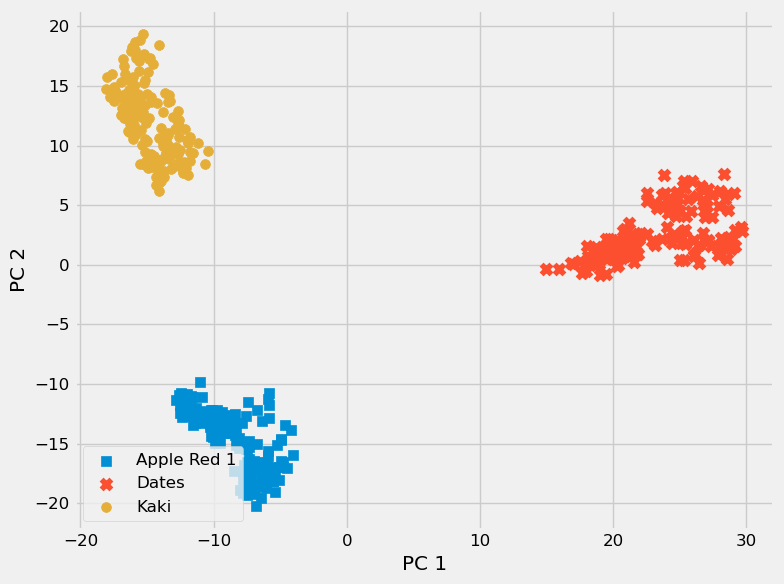

In [40]:
plot_pca(X_pca, y)

In [41]:
df_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pcaFeatures: vector (nullable = true)



In [42]:
# vector to array
df_pca = df_pca.withColumn("pcaFeatures", vector_to_array("pcaFeatures"))
df_pca = df_pca.select('path', 'label', 'pcaFeatures')
df_pca.show(5)

+--------------------+-----------+--------------------+
|                path|      label|         pcaFeatures|
+--------------------+-----------+--------------------+
|file:/C:/Users/mu...|Apple Red 1|[-6.2871393865860...|
|file:/C:/Users/mu...|Apple Red 1|[-5.9051367560626...|
|file:/C:/Users/mu...|Apple Red 1|[-6.7050055947995...|
|file:/C:/Users/mu...|Apple Red 1|[-7.3259522917575...|
|file:/C:/Users/mu...|Apple Red 1|[-6.6761411351968...|
+--------------------+-----------+--------------------+
only showing top 5 rows



In [43]:
df_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pcaFeatures: array (nullable = false)
 |    |-- element: double (containsNull = false)



In [44]:
print(PATH_Result)

C:\Users\multi\Desktop\Projets_DS\P8_ds/data/Results


### Enregistrement des données

In [45]:
# au format parquet
df_pca.write.mode("overwrite").parquet(PATH_Result)

In [46]:
# df_pca = spark.read.parquet(PATH_Result)

In [47]:
df = df_pca.select("*").toPandas()

In [48]:
df.head()

,path,label,pcaFeatures
0,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-6.287139386586003, -17.056464787267654, -2.4..."
1,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-5.905136756062631, -17.296257849603094, -2.5..."
2,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-6.705005594799506, -12.167035846753548, -3.6..."
3,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-7.3259522917575355, -16.293423930727133, -5...."
4,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-6.676141135196839, -16.836243784648985, -6.7..."


In [49]:
df.to_csv("{}/results.csv".format(PATH_Result), index=False)

In [50]:
# Lecture du fichier csv
df = pd.read_csv("{}/results.csv".format(PATH_Result))
df.head()

,path,label,pcaFeatures
0,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-6.287139386586003, -17.056464787267654, -2.4..."
1,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-5.905136756062631, -17.296257849603094, -2.5..."
2,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-6.705005594799506, -12.167035846753548, -3.6..."
3,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-7.3259522917575355, -16.293423930727133, -5...."
4,file:/C:/Users/multi/Desktop/Projets_DS/P8_ds/...,Apple Red 1,"[-6.676141135196839, -16.836243784648985, -6.7..."


Nous venons de valider le processus sur un jeu de données allégé en local <br />
où nous avons simulé un cluster de machines en répartissant la charge de travail <br />
sur différents cœurs de processeur au sein d'une même machine.

Nous allons maintenant généraliser le processus en déployant notre solution <br />
sur un réel cluster de machines et nous travaillerons désormais sur la totalité <br />
des 22819 images de notre dossier "Test".